In [210]:
import sys
from mcap_protobuf.decoder import DecoderFactory
from mcap.reader import make_reader
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

files = [
    "/home/kuribayashi-a/Downloads/trial38/20250815-150430.00000.compact.mcap",
    "/home/kuribayashi-a/Downloads/trial39/20250815-150848.00000.compact.mcap", 
    "/home/kuribayashi-a/Downloads/trial40/20250815-151252.00000.compact.mcap",
    "/home/kuribayashi-a/Downloads/trial41/20250815-153107.00000.compact.mcap",
    "/home/kuribayashi-a/Downloads/trial42/20250815-153535.00000.compact.mcap",
    "/home/kuribayashi-a/Downloads/trial43/20250815-153953.00000.compact.mcap",
    "/home/kuribayashi-a/Downloads/trial45/20250815-154851.00000.compact.mcap",
    "/home/kuribayashi-a/Downloads/trial46/20250815-155329.00000.compact.mcap",
    "/home/kuribayashi-a/Downloads/trial47/20250815-155749.00000.compact.mcap",
    "/home/kuribayashi-a/Downloads/trial48/20250815-160153.00000.compact.mcap",
]

def plot_data(data, x, y, title):
    fix, ax = plt.subplots()
    sns.lineplot(data=data, x=x, y=y, hue="label")
    fig.regend()
    plt.legend(loc="lower center", bbox_to_anchor=(-1, 1.0), ncol=4)
    # plt.savefig(f"{title}.svg")

log = []

for i in range(0, len(files)):      
    with open(files[i], "rb") as f:
        reader = make_reader(f, decoder_factories=[DecoderFactory()])
        
        
        is_ad_mode = False
        is_log = True
        distance = 0.0
        last_pose = []
        speed = None
        acceleration = None
        d_front = None
        obstacle_id = None
        obstacle_type = None
        for schema, channel, message, proto_msg in reader.iter_decoded_messages():

    
            # print(is_time)
    
            if channel.topic == "/apollo/canbus/chassis":
                is_ad_mode = (proto_msg.driving_mode == 1)

            if channel.topic == "/apollo/localization/pose":
                if last_pose:
                    d = ((last_pose[0]-proto_msg.pose.position.x)**2+(last_pose[1]-proto_msg.pose.position.y)**2)**0.5
                    # print(d)
                    # if d < 0.1:
                    #     is_log = False
                    # else:
                    #     is_log = True
                    #     distance += d
                    #     last_pose = [proto_msg.pose.position.x, proto_msg.pose.position.y]
                    distance += d
                    last_pose = [proto_msg.pose.position.x, proto_msg.pose.position.y]
                else:
                    last_pose = [proto_msg.pose.position.x, proto_msg.pose.position.y]

            if channel.topic == "/apollo/canbus/chassis":
                speed = proto_msg.speed_mps*3.6
                
            if channel.topic == "/apollo/control":
                acceleration = proto_msg.acceleration

            if channel.topic == "/apollo/planning":
                d_front_list = []
                id_list = []
                for obstacle in proto_msg.debug.obstacles.obstacle:
                    if obstacle.width == 30:
                        d_front_list.append(obstacle.d_front)
                        id_list.append(obstacle.length)

                if d_front_list:
                    d_front = min(d_front_list)
                    obstacle_id = id_list[d_front_list.index(d_front)]
                    

            if is_ad_mode and is_log and speed is not None and acceleration is not None:
                # print(distance, speed)
                log.append([
                    distance,
                    speed,
                    acceleration,
                    d_front,
                    obstacle_id,
                    i
                ])
                speed = None
                acceleration = None
                d_front = None


In [211]:
log2 = []
for l in log:
    if l[4] == 6:
        l[0] -= 20
    log2.append(l)

df = pd.DataFrame(log, columns=["distance", "speed", "acceleration", "d_front", "stop_type", "trial"])

In [212]:
stop_type_name = {2:"temporary", 3:"exit"}
stop_list = []
for trial in df.trial.drop_duplicates():
    for stop_type in df.stop_type.drop_duplicates():
        target_df = df[(df.trial==trial)&(df.stop_type==stop_type)&(df.speed<1.0)]
        stop_list.append([stop_type_name[stop_type], target_df.d_front.min(), trial])

stop_list_df = pd.DataFrame(data=stop_list, columns=["stop_type", "distance", "trial"])

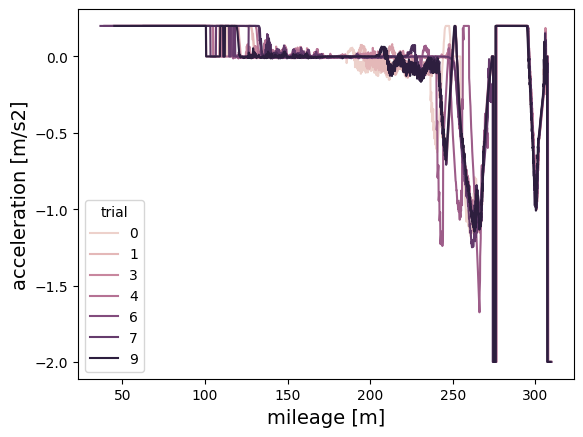

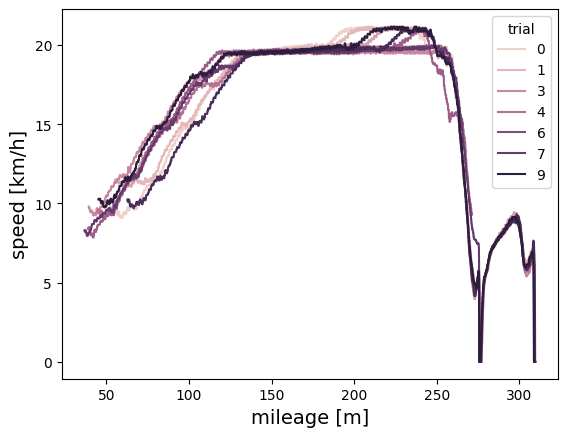

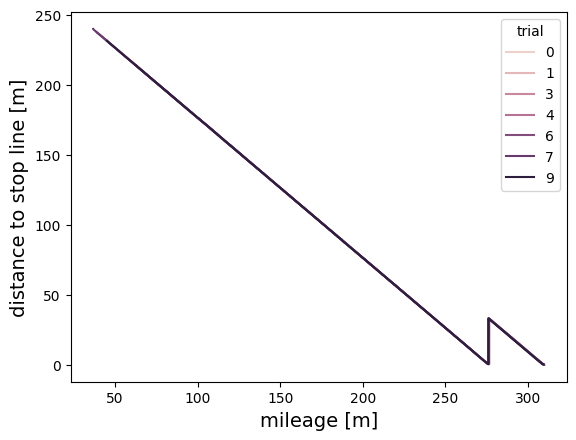

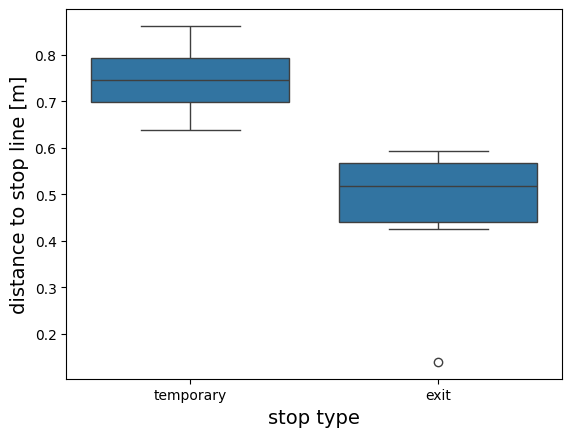

In [220]:
fix, ax = plt.subplots()
sns.lineplot(data=df, x="distance", y="acceleration", hue="trial", ax=ax)
ax.set_xlabel("mileage [m]", fontsize=14)
ax.set_ylabel("acceleration [m/s2]", fontsize=14)
plt.savefig("mec_demo#1_accel.svg")

fix, ax = plt.subplots()
sns.lineplot(data=df, x="distance", y="speed", hue="trial", ax=ax)
ax.set_xlabel("mileage [m]", fontsize=14)
ax.set_ylabel("speed [km/h]", fontsize=14)
plt.savefig("mec_demo#1_speed.svg")

fix, ax = plt.subplots()
sns.lineplot(data=df, x="distance", y="d_front", hue="trial", ax=ax)
ax.set_xlabel("mileage [m]", fontsize=14)
ax.set_ylabel("distance to stop line [m]", fontsize=14)
plt.show()


fix, ax = plt.subplots()
sns.boxplot(data=stop_list_df, x="stop_type", y="distance", ax=ax)
ax.set_xlabel("stop type", fontsize=14)
ax.set_ylabel("distance to stop line [m]", fontsize=14)
plt.savefig("mec_demo#1_distance.svg")

In [2]:
offset_list = [0]
for file_idx in range(1, len(files)):
    diff_list = []
    pose_0 = acceleration_list[0]
    pose_1 = acceleration_list[file_idx]
    for offset in range(-100, 100):
        diff = 0.0
        if offset>=0:
            for i in range(0, len(pose_0)):
                if i+offset >= len(pose_1): break
                diff += (pose_0[i] - pose_1[i+offset])**2
                diff_list.append(diff)
        else:
            for i in range(0, len(pose_1)):
                if i+offset >= len(pose_0): break
                diff += (pose_0[i+offset] - pose_1[i])**2
                offset_list = [o+diff for o in offset_list]
                offset_list.append(0)
        
    offset_list.append(diff_list.index(min(diff_list))*-1)
    print(diff_list.index(min(diff_list)), min(diff_list))



27610 3.9384259097516294e-18



KeyboardInterrupt

